In [ ]:
!pip install hdbscan
!pip install librosa
!pip install das_unsupervised

In [9]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import librosa.feature
import librosa.display
from matplotlib.colors import ListedColormap
import sklearn.metrics
import scipy.stats
import hdbscan
import umap
import pandas as pd
import scipy.io.wavfile
import glob
import os
import das_unsupervised.spec_utils
import argparse

In [10]:
home_path = '/Volumes/RENATA_X/Vallentinlab'
birdfolder = 'bird7159'
channel = 'chan6'

### !!! these csv file should start with dph+day, e.g, dph100

args = {'inPath':os.path.join(home_path,birdfolder+'_sorted',channel,'dph'),'fileType':'csv'}
file_list = sorted(glob.glob(args['inPath']+'*_filtered_denoised_sampled*.'+args['fileType']))
specs = []
amps = []
types = []
durations = []
print(len(file_list))

67


In [16]:
# these parameters allow you to select a specific frequency range and to threshold noise
# optimize them by visually inspecting the plotted spectrograms below this cell
freq_min_idx = 4
freq_max_idx = -1
freq_step_idx = 2
amplitude_thres = 2
day_label = np.empty((0,))

last_label = 0

for csv_file in file_list:
    annotations = pd.read_csv(csv_file)
    fname = os.path.split(csv_file)[1]
    syllables = annotations.loc[annotations.name==4]##syllables = annotations.loc[annotations.name=='syllable']
    print(f"{len(syllables)} annotated syllables.")
    day_index = int(os.path.split(os.path.splitext(fname)[0])[-1][3:6])
    day_label = np.concatenate((day_label,np.repeat(day_index,len(syllables))))
    last_label = last_label+len(syllables)
    del annotations

3 annotated syllables.
19 annotated syllables.
6 annotated syllables.
36 annotated syllables.
18 annotated syllables.
44 annotated syllables.
9 annotated syllables.
72 annotated syllables.
104 annotated syllables.
172 annotated syllables.
178 annotated syllables.
119 annotated syllables.
43 annotated syllables.
156 annotated syllables.
146 annotated syllables.
199 annotated syllables.
126 annotated syllables.
126 annotated syllables.
139 annotated syllables.
170 annotated syllables.
123 annotated syllables.
64 annotated syllables.
168 annotated syllables.
169 annotated syllables.
131 annotated syllables.
113 annotated syllables.
141 annotated syllables.
138 annotated syllables.
0 annotated syllables.
129 annotated syllables.
153 annotated syllables.
102 annotated syllables.
121 annotated syllables.
121 annotated syllables.
129 annotated syllables.
3 annotated syllables.
104 annotated syllables.
131 annotated syllables.
124 annotated syllables.
67 annotated syllables.
149 annotated syll

In [18]:
for csv_file in file_list:
    fname = os.path.split(csv_file)[1]
    wav_file = os.path.splitext(csv_file)[0][:-12]+'.wav'
    print(wav_file)
    # load recording and annotations
    fs, x = scipy.io.wavfile.read(wav_file)
    x = x.astype(float)
    print(f"{len(x)} samples at {fs} Hz.")

    annotations = pd.read_csv(csv_file)
    
    syllables = annotations.loc[annotations.name==4]##syllables = annotations.loc[annotations.name=='syllable']
    print(f"{len(syllables)} annotated syllables.")
    del annotations
    hop_length = int(2 * fs / 1000)
    win_length = int(10 * fs / 1000 * 2)
    specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)
    # specgram = specgram[np.where(specgram[:,0]!=0)[0],:]
    sm = np.median(specgram, axis=1)
    
    del x

    onsets = syllables['start_seconds'] * fs  # samples
    offsets = syllables['stop_seconds'] * fs  # samples
    for cnt, (onsets, offsets) in enumerate(zip(onsets, offsets)):
        tmp = np.log2(specgram[:, int(onsets/hop_length):int(offsets/hop_length)] / sm[:, np.newaxis])
        
        amps.append(np.var(tmp))
        tmp = tmp[freq_min_idx:freq_max_idx:freq_step_idx, :]
        tmp = np.clip(tmp - amplitude_thres, 0, np.inf)
        specs.append(tmp)
        durations.append((offsets-onsets) / fs)
    del specgram
    

    print(f"Got {len(specs)} syllables.")
    print(onsets)

spec_rs = [das_unsupervised.spec_utils.log_resize_spec(spec, scaling_factor=8) for spec in specs]
max_len = np.max([spec.shape[1] for spec in spec_rs]) + 1
spec_rs = [das_unsupervised.spec_utils.pad_spec(spec, pad_length=max_len) for spec in spec_rs]

spec_flat = [spec.ravel() for spec in spec_rs]
spec_flat = np.stack(spec_flat, axis=1)

/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph033_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
3 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[ 6.  8.  8. ... -2. -2. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)
/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:26: RuntimeWarning: divide by zero encountered in true_divide
  tmp = np.log2(specgram[:, int(onsets/hop_length):int(offsets/hop_length)] / sm[:, np.newaxis])
/Users/yirongx/opt/miniconda3/envs/das/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Got 3 syllables.
5070752.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph034_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
19 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[295. 247. 152. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)
/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:26: RuntimeWarning: divide by zero encountered in true_divide
  tmp = np.log2(specgram[:, int(onsets/hop_length):int(offsets/hop_length)] / sm[:, np.newaxis])
/Users/yirongx/opt/miniconda3/envs/das/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Got 22 syllables.
6058816.000000001
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph035_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
6 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-590. -474. -385. ... 1295. 1261.  761.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)
/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:26: RuntimeWarning: divide by zero encountered in true_divide
  tmp = np.log2(specgram[:, int(onsets/hop_length):int(offsets/hop_length)] / sm[:, np.newaxis])
/Users/yirongx/opt/miniconda3/envs/das/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Got 28 syllables.
5793600.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph036_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
36 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[136. 150.  97. ...  -2. -14.  -9.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)
/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:26: RuntimeWarning: divide by zero encountered in true_divide
  tmp = np.log2(specgram[:, int(onsets/hop_length):int(offsets/hop_length)] / sm[:, np.newaxis])
/Users/yirongx/opt/miniconda3/envs/das/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Got 64 syllables.
7161008.000000001
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph037_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
18 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-1584. -1334.  -919. ...     0.     0.     0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)
/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:26: RuntimeWarning: divide by zero encountered in true_divide
  tmp = np.log2(specgram[:, int(onsets/hop_length):int(offsets/hop_length)] / sm[:, np.newaxis])
/Users/yirongx/opt/miniconda3/envs/das/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Got 82 syllables.
6853568.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph038_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
44 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-108.  -73.  -26. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 126 syllables.
7125296.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph040_filtered_denoised_sampled.wav
2999995 samples at 40000 Hz.
9 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-198. -159.  -80. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)
/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:26: RuntimeWarning: divide by zero encountered in true_divide
  tmp = np.log2(specgram[:, int(onsets/hop_length):int(offsets/hop_length)] / sm[:, np.newaxis])
/Users/yirongx/opt/miniconda3/envs/das/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Got 135 syllables.
2159424.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph041_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
72 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-168. -115.  -69. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 207 syllables.
7024704.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph043_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
104 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-107.  -69.  -52. ...   -6.   -2.   10.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 311 syllables.
7184192.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph044_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
172 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[93. 54. 13. ... -6.  0.  3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 483 syllables.
7139920.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph045_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
178 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[  -1.    5.   -1. ...  133. -117. -320.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 661 syllables.
7051056.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph046_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
119 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[393. 303. 240. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 780 syllables.
6944127.999999999
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph047_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
43 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[83. 58. 43. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)
/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:26: RuntimeWarning: divide by zero encountered in true_divide
  tmp = np.log2(specgram[:, int(onsets/hop_length):int(offsets/hop_length)] / sm[:, np.newaxis])
/Users/yirongx/opt/miniconda3/envs/das/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Got 823 syllables.
7106000.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph048_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
156 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-396. -428. -268. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 979 syllables.
6996928.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph049_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
146 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[970. 767. 622. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 1125 syllables.
7168064.000000001
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph050_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
199 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-1.375e+03 -1.175e+03 -9.510e+02 ... -1.000e+00  0.000e+00 -2.000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 1324 syllables.
7126079.999999999
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph051_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
126 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-822. -820. -615. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 1450 syllables.
6980720.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph052_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
126 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[374. 253. 192. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 1576 syllables.
7171680.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph053_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
139 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[256. 220. 159. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 1715 syllables.
6982048.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph054_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
170 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[455. 334. 229. ... -39. -32. -25.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 1885 syllables.
7168464.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph055_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
123 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-16. -17.   8. ...   0.   0.  -4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 2008 syllables.
7122944.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph056_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
64 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-850. -741. -558. ...   -4.    1.    5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 2072 syllables.
6757696.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph057_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
168 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[ -572.  -309.    45. ... -2599. -2136.   535.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 2240 syllables.
7179376.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph058_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
169 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-592. -380. -277. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 2409 syllables.
7110720.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph059_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
131 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-563. -389. -219. ...  -13.   -5.   -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 2540 syllables.
7061088.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph060_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
113 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[97. 32. 14. ...  1.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 2653 syllables.
7068096.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph061_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
141 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[344. 220. 146. ...   0.   2.  -8.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 2794 syllables.
6994768.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph062_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
138 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[ 91.  26.  -4. ... 395. 844. 826.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 2932 syllables.
7136896.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph063_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
0 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[240. 207. 154. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 2932 syllables.
Series([], Name: start_seconds, dtype: float64)
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph064_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
129 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-9.63e+02 -1.07e+03 -6.51e+02 ... -1.00e+00  0.00e+00  1.00e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 3061 syllables.
7071728.000000001
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph065_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
153 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-10.   1.   4. ...   0.   0.  -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 3214 syllables.
7170752.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph066_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
102 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-552. -491. -408. ...   36.  867. 1005.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 3316 syllables.
7184240.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph067_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
121 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[1450. 1263.  870. ... -196. -481. -429.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 3437 syllables.
6672528.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph068_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
121 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[ 400.  319.  233. ...  -59. -129. -185.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 3558 syllables.
7172592.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph069_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
129 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-183. -121.  -70. ...   -3.    1.    5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 3687 syllables.
7157840.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph070_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
3 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-1201. -1065.  -662. ...     0.     0.     0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)
/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:26: RuntimeWarning: divide by zero encountered in true_divide
  tmp = np.log2(specgram[:, int(onsets/hop_length):int(offsets/hop_length)] / sm[:, np.newaxis])
/Users/yirongx/opt/miniconda3/envs/das/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Got 3690 syllables.
5320512.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph071_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
104 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[ 541.  373.  256. ...   22.  -82. -162.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 3794 syllables.
7036352.000000001
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph072_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
131 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-284. -182. -129. ...  793. 1349. 1605.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 3925 syllables.
6909696.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph073_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
124 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-323. -245. -156. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 4049 syllables.
7060288.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph074_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
67 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[1219. 1057.  704. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 4116 syllables.
7115200.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph075_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
149 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-476. -382. -266. ...    2.    6.  -12.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 4265 syllables.
7182816.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph076_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
121 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-5023. -4920. -3146. ...     0.     0.     0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 4386 syllables.
7138080.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph077_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
121 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-360. -256. -179. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 4507 syllables.
7094112.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph078_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
125 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[469. 308. 232. ...   1.  -1.  -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 4632 syllables.
7023792.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph079_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
96 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[0. 2. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 4728 syllables.
6917184.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph080_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
98 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[917. 740. 558. ...   0.   0.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 4826 syllables.
6987088.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph081_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
95 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[ -138.   -85.   -73. ...  -656. -1982. -2413.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 4921 syllables.
7190032.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph082_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
66 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[4962. 4216. 1799. ...  -25.  -26.  -22.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 4987 syllables.
7186624.000000001
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph083_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
98 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[1410. 1123.  814. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5085 syllables.
6983792.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph084_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
36 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[1735. 1603. 1090. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5121 syllables.
7055359.999999999
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph085_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
95 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[97. 78. 56. ... -1.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5216 syllables.
6939120.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph086_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
92 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[ 76.  34.  18. ... -86. -73. -65.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5308 syllables.
7108352.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph087_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
108 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-502. -363. -253. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5416 syllables.
7147456.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph088_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
64 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-1336. -1087.  -627. ...     0.     0.     0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5480 syllables.
7125936.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph089_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
77 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[1915. 1806. 1193. ...  112.  107.  134.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5557 syllables.
7187776.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph090_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
77 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-360. -263. -144. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5634 syllables.
6993392.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph091_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
50 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-419. -348. -251. ... -139.  -90.   15.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5684 syllables.
7189408.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph095_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
41 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[2474. 2261. 1162. ...   97.  -33.   26.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5725 syllables.
6996576.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph100_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
98 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[4175. 4056. 2569. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5823 syllables.
7136912.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph105_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
75 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[464. 321. 239. ...  -1.   0.   1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5898 syllables.
6908224.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph110_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
86 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[67. 45. 33. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 5984 syllables.
7070400.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph115_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
43 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-1395. -1317.  -902. ...     0.     0.     0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 6027 syllables.
7135008.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph121_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
66 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[106.  44.  22. ...   0.  -2.   0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 6093 syllables.
7019344.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph122_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
68 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[1.001e+03 7.310e+02 4.170e+02 ... 1.000e+00 1.000e+00 0.000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 6161 syllables.
7148816.000000001
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph123_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
65 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[-3.134e+03 -2.982e+03 -1.843e+03 ... -4.000e+00 -4.000e+00 -3.000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 6226 syllables.
6886064.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph124_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
76 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[ -281.  -214.  -111. ... -2294.  -446.  1605.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)


Got 6302 syllables.
6993552.0
/Volumes/RENATA_X/Vallentinlab/bird7159_sorted/chan6/dph126_filtered_denoised_sampled.wav
7200000 samples at 40000 Hz.
44 annotated syllables.


/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:17: FutureWarning: Pass y=[1011.  833.  608. ...    0.    0.    0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  specgram = librosa.feature.melspectrogram(x, sr=fs, n_fft=win_length, hop_length=hop_length, power=2)
/var/folders/4g/xkgvwyyx62l00dd1sldy15tr0000gn/T/ipykernel_67663/3780661307.py:26: RuntimeWarning: divide by zero encountered in true_divide
  tmp = np.log2(specgram[:, int(onsets/hop_length):int(offsets/hop_length)] / sm[:, np.newaxis])
/Users/yirongx/opt/miniconda3/envs/das/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Got 6346 syllables.
7139344.0


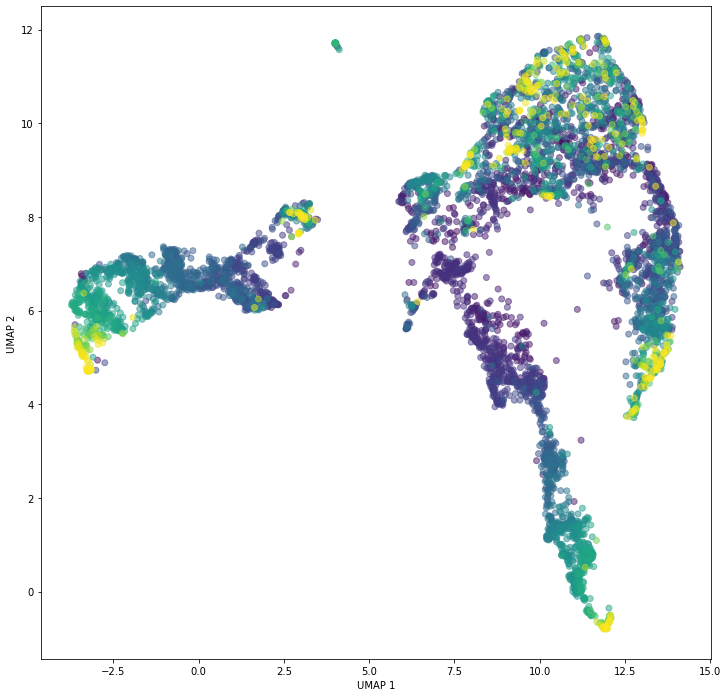

In [69]:
day_labels = day_label[~(np.max(spec_flat,axis=0)==0)]
spec_flat[np.isnan(spec_flat)] = 0
spec_flat[np.isinf(spec_flat)] = 0
spec_flat_new = spec_flat[:,~(np.max(spec_flat,axis=0)==0)]
out = umap.UMAP(min_dist=0.08, n_neighbors=20).fit_transform(spec_flat_new.T)
#hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=20).fit_predict(out)
plt.figure(figsize=(12, 12))
plt.scatter(out[:,0], out[:,1],c=day_labels,alpha=.5) #c=types
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

# save csv file

In [60]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
distA=pdist(out,metric='euclidean')
distB = squareform(distA)


In [61]:
day_labels_save = np.array(['%03d'%label for label in (day_labels/10).astype(int)*10])
arr = np.concatenate([out.T,day_labels_save.reshape((1,len(day_labels))),np.arange(1,len(day_labels)+1).reshape((1,len(day_labels)))],axis=0).T
pd.DataFrame(arr).to_csv('umap_pred.csv',sep=',',index=False, header=False)



In [68]:
sylmtx_20 = np.zeros((out.shape[0],20))

for i in range(distB.shape[0]):
    sylmtx_20[i,:]=np.argsort(distB[:,i])[0:20]
np.savetxt('sylmtx_20.csv',sylmtx_20,delimiter=',')
np.savetxt('sylmtx_pred.csv',spec_flat_new*255/np.max(spec_flat_new),delimiter=',')

In [33]:
print(max_len)

48
